In [32]:
import os
import sys

sys.path.append(os.path.join('..', 'benchmarks'))

import pgf_plotting

pgf_plotting.configure_matplotlib_pgf()

%pylab --no-import-all inline

import scipy.signal as ss

Populating the interactive namespace from numpy and matplotlib


In [33]:
plt.rcParams.update({'figure.figsize': (10, 6)})

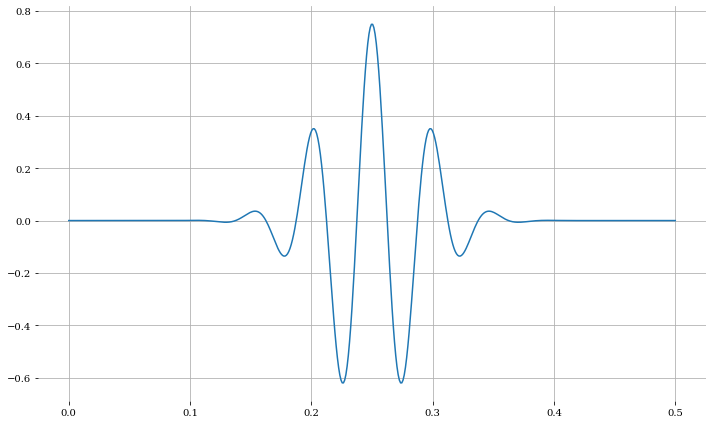

In [34]:
# use Morlet wavelet as our reference position signal
N = 500
x_ref = np.real(ss.morlet(N))

# time
fs = 1000
Ts = 1 / fs
time = np.linspace(0, N * Ts, N)

plt.plot(time, x_ref);

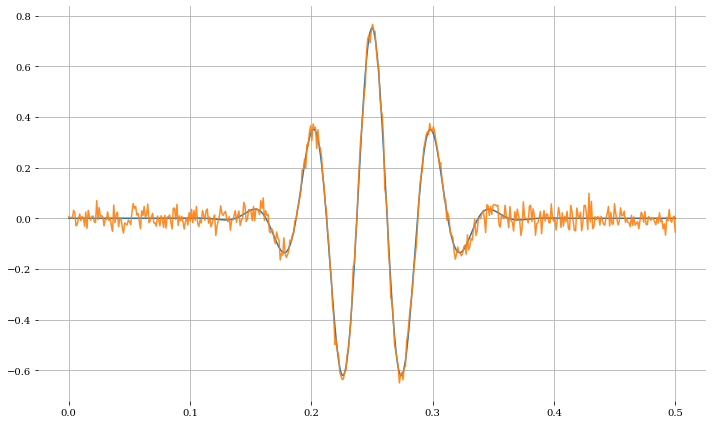

In [35]:
# add some noise, mostly Gaussian (as Kalman filter assumes Gaussian noise), 
# but add some white noise (with 0 mean) too, just to make estimation harder
K_gaussian, K_white = 0.025, 0.015
x_err_gaussian = K_gaussian * np.random.randn(N)
x_err_white = K_white * (np.random.rand(N) * 2 - 1.0)

x_meas = x_ref + x_err_gaussian + x_err_white

plt.plot(time, x_ref, alpha=1.0);
plt.plot(time, x_meas, alpha=0.9);

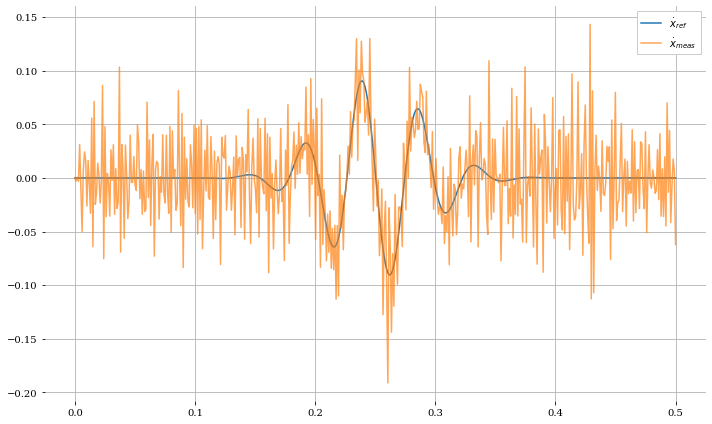

In [36]:
# now estimate velocity with backward differences, use zero initial condition
dx_0 = 0
dx_meas = np.concatenate(([dx_0], np.diff(x_meas)))
dx_ref = np.concatenate(([dx_0], np.diff(x_ref)))

plt.plot(time, dx_ref, label=r'$\dot{x}_{ref}$')
plt.plot(time, dx_meas, label=r'$\dot{x}_{meas}$', alpha=0.7)
plt.legend();

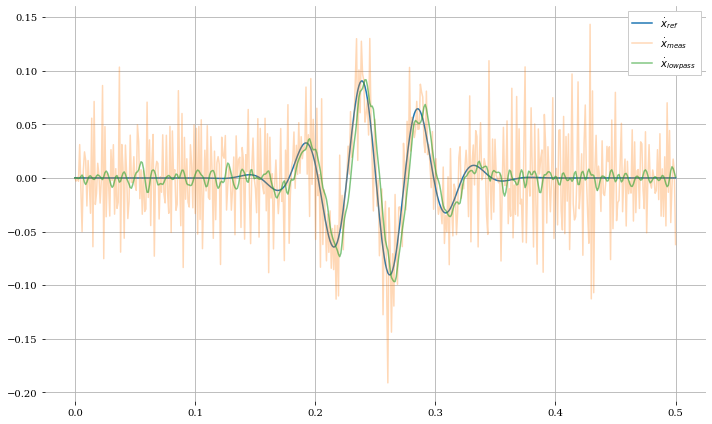

In [37]:
# now, when we know the results are quite bad...
# let's use simple low pass filter
order = 3
cutoff = 100
b, a = ss.iirfilter(order, btype='lowpass', Wn=cutoff, fs=fs)
dx_meas_lowpass = ss.lfilter(b, a, dx_meas)

plt.plot(time, dx_ref, label=r'$\dot{x}_{ref}$')
plt.plot(time, dx_meas, label=r'$\dot{x}_{meas}$', alpha=0.3)
plt.plot(time, dx_meas_lowpass, label=r'$\dot{x}_{lowpass}$', alpha=0.6)
plt.legend();

In [38]:
# this introduced time lag and is still not ideal
# increasing cutoff frequency leaves more noise, decreasing increases lag
# now try to use Kalman filter, copy pasted from (but there is nice explanation)
# https://medium.com/@jaems33/understanding-kalman-filters-with-python-2310e87b8f48

# acceleration at t=0
d2x_0 = 0.0

# Something must be wrong here?
Maybe check other sources, spend more time on this:
https://www.kalmanfilter.net/kalman1d.html

In [55]:
x_observations = x_meas.copy()
v_observations = dx_meas.copy()

z = np.c_[x_observations, v_observations]

# Initial Conditions
a = d2x_0  # Acceleration
v = dx_0
t = Ts  # Difference in time

# Process / Estimation Errors
error_est_x = 2
error_est_v = 1

# Observation Errors
error_obs_x = 0.0010  # Uncertainty in the measurement
error_obs_v = 0.003


def prediction2d(x, v, t, a):
    A = np.array([[1, t],
                  [0, 1]])
    X = np.array([[x],
                  [v]])
    B = np.array([[0.5 * t**2],
                  [t]])
    X_prime = A.dot(X) + B.dot(a)
    return X_prime


def covariance2d(sigma1, sigma2):
    cov1_2 = sigma1 * sigma2
    cov2_1 = sigma2 * sigma1
    cov_matrix = np.array([[sigma1 ** 2, cov1_2],
                           [cov2_1, sigma2 ** 2]])
    return np.diag(np.diag(cov_matrix))


# Initial Estimation Covariance Matrix
P = covariance2d(error_est_x, error_est_v)
A = np.array([[1, t],
              [0, 1]])

# Initial State Matrix
X = np.array([[z[0][0]],
              [v]])
n = len(z[0])

X_history = [X]
P_history = [P]
K_history = [np.zeros([2, 2])]

for data in z[1:]:
    X = prediction2d(X[0][0], X[1][0], t, a)
    # To simplify the problem, professor
    # set off-diagonal terms to 0.
    P = np.diag(np.diag(A.dot(P).dot(A.T)))

    # Calculating the Kalman Gain
    H = np.identity(n)
    R = covariance2d(error_obs_x, error_obs_v)
    S = H.dot(P).dot(H.T) + R
    K = P.dot(H).dot(np.linalg.inv(S))

    # Reshape the new data into the measurement space.
    Y = H.dot(data).reshape(n, -1)

    # Update the State Matrix
    # Combination of the predicted state, measured values, covariance matrix and Kalman Gain
    X = X + K.dot(Y - H.dot(X))

    # Update Process Covariance Matrix
    P = (np.identity(len(K)) - K.dot(H)).dot(P)

    # saves values to history
    X_history.append(X)
    P_history.append(P)
    K_history.append(K)
    
print("Kalman Filter State Matrix:\n", X)

Kalman Filter State Matrix:
 [[-0.00050318]
 [-0.0001201 ]]


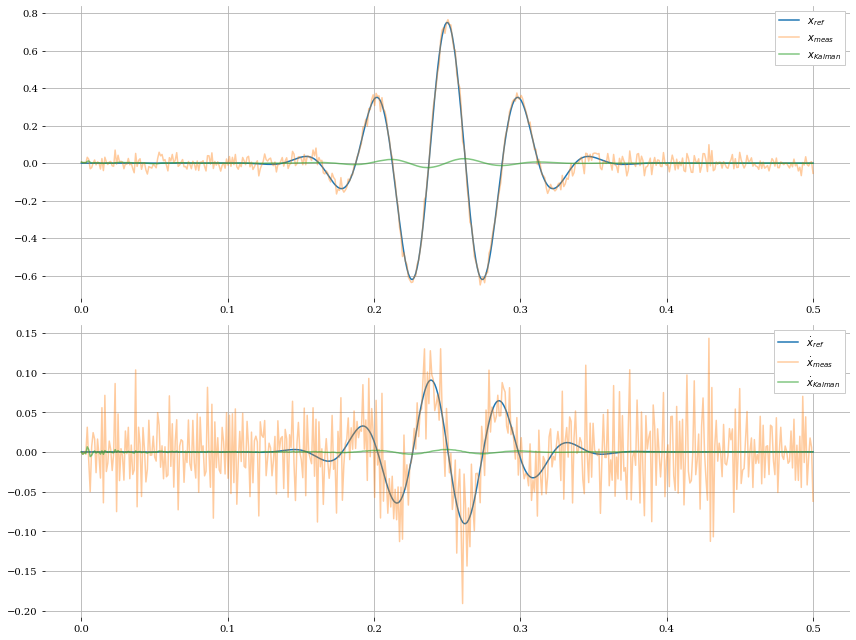

In [66]:
# let's see the results
X_history = np.squeeze(np.array(X_history))
P_history = np.squeeze(np.array(P_history))
K_history = np.squeeze(np.array(K_history))

x_kalman = X_history[:, 0]
dx_kalman = X_history[:, 1]

fig, axes = plt.subplots(2, figsize=(12, 9))
ax1 = axes[0]
ax2 = axes[1]

ax1.plot(time, x_ref, label=r'$x_{ref}$')
ax1.plot(time, x_meas, label=r'$x_{meas}$', alpha=0.4)
ax1.plot(time, x_kalman, label=r'$x_{Kalman}$', alpha=0.6)
ax1.legend();

ax2.plot(time, dx_ref, label=r'$\dot{x}_{ref}$')
ax2.plot(time, dx_meas, label=r'$\dot{x}_{meas}$', alpha=0.4)
# ax2.plot(time, dx_meas_lowpass, label=r'$\dot{x}_{lowpass}$', alpha=0.6)
ax2.plot(time, dx_kalman, label=r'$\dot{x}_{Kalman}$', alpha=0.6)
ax2.legend();

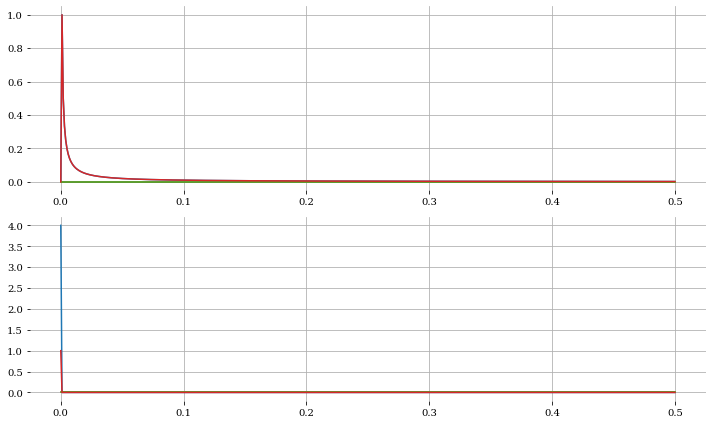

In [67]:
fig, axes = plt.subplots(2)

axes[0].plot(time, K_history[:, 0, 0])
axes[0].plot(time, K_history[:, 0, 1])
axes[0].plot(time, K_history[:, 1, 0])
axes[0].plot(time, K_history[:, 1, 1])

axes[1].plot(time, P_history[:, 0, 0])
axes[1].plot(time, P_history[:, 0, 1])
axes[1].plot(time, P_history[:, 1, 0])
axes[1].plot(time, P_history[:, 1, 1]);